In [3]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

In [4]:
url_api = "https://api.dofusdb.fr/quest-categories/19?lang=fr" # catégorie incarnam
req = requests.get(url_api)
wb = req.json()
df = pd.json_normalize(wb) 
questIds = df.questIds[0] # liste des ids des quêtes de catégorie incarnam

In [8]:
url_api = "https://api.dofusdb.fr/achievements/1378" # succès des quêtes principales d'incarnam
req = requests.get(url_api)
wb = req.json()
df = pd.json_normalize(wb) 
df = pd.json_normalize(df.objectives.values[0]) # objectives
for i in range(len(df)) : # rajoute les ids de ces quêtes
    questIds.append(pd.json_normalize(df.iloc[i].readableCriterion[0][1]).id[0]) # readableCriterion : 0 : 1 : (id 1 par 1)

In [13]:
coord = pd.DataFrame(columns=['map.posY','map.posX']) # initialise DataFrame des coordonnées des maps où se rendre
for i in range(len(questIds)) :
    url_api = "https://api.dofusdb.fr/quests?id="+str(questIds[i])
    req = requests.get(url_api)
    wb = req.json()
    df = pd.json_normalize(wb) # la page de la quête 
    df = pd.json_normalize(df.data.values[0]) # data 
    if "steps" in df.columns:
        df = pd.json_normalize(df.steps.values[0]) # steps 
        df = pd.json_normalize(df.objectives.values[0]) # objectives
        if 'map.posY' in df.columns :
            df = df[["map.posY","map.posX"]] # pos
            coord = pd.concat([coord, df])

In [30]:
coord.rename(columns = {'map.posY':'Y', 'map.posX':'X'}, inplace = True) # renommage
coord_size = coord.groupby(['Y', 'X'], as_index=False).size() # calcule les effectifs de chaque coord
coord_size.drop(coord_size[(coord_size.Y > 1) | (coord_size.Y < -6)].index,inplace=True)
coord_size.drop(coord_size[(coord_size.X > 5) | (coord_size.X < -3)].index,inplace=True) # supprimer les coord hors incarnam
grid = coord_size.pivot(index="Y",columns="X", values="size") # DataFrame à 2 index pour obtenir la heatmap
grid.columns = grid.columns.astype(np.int64)
grid.index = grid.index.astype(np.int64) # conversion des coordonnées en entier

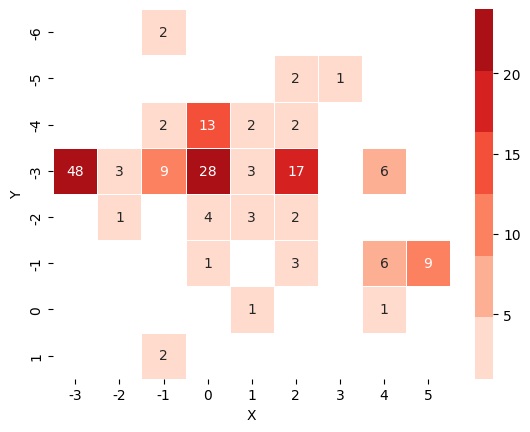

In [31]:
sns.heatmap(grid, annot=True, linewidth=.5, cmap=sns.color_palette("Reds"),vmax=24)
plt.show()

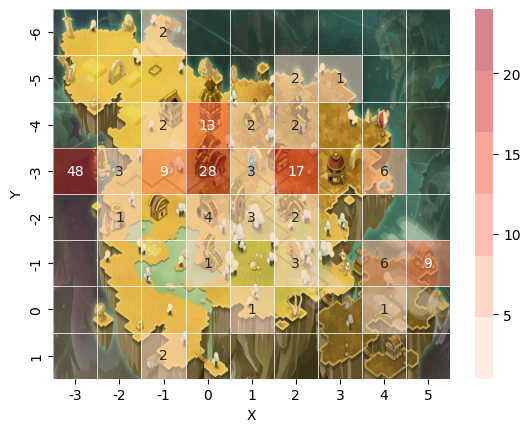

In [35]:
# get the map image as an array so we can plot it 
import matplotlib.cm
import matplotlib.image as mpimg

map_img = mpimg.imread('heatmap/incarnam_map.PNG') 

hmax = sns.heatmap(grid,
            cmap = sns.color_palette("Reds"),
            alpha = 0.5, # whole heatmap is translucent
            annot = True,
            zorder = 2,
            linewidth=.5,
            vmax=24
            )

# heatmap uses pcolormesh instead of imshow, so we can't pass through 
# extent as a kwarg, so we can't mmatch the heatmap to the map. Instead, 
# match the map to the heatmap:

hmax.imshow(map_img,
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 1) #put the map under the heatmap

plt.show()